# [LAB 13] 3. 통계적 시계열 분석의 접근 - ACF / PACF

### #01. 준비작업
#### 1. 라이브러리 가져오기

In [1]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

# ADF 테스트 - 정상성 확인용
from statsmodels.tsa.stattools import adfuller

# ACF, PACF 테스트
from statsmodels.tsa.stattools import acf, pacf

# ACF, PACF 시각화 기능
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#### 2. 그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 3. 데이터 가져오기

In [3]:
origin = load_data('air_passengers')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/lab13_/air_passengers.xlsx
[desc] 어느 항공사의 월간 탑승객 수 (출처: https://www.kaggle.com/datasets/rakannimer/air-passengers)
[!] Cannot read metadata

==== 데이터 크기 확인 ====
데이터셋 크기: (144, 2)
열 개수: 2
행 개수: 144

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


#### 4. 데이터 전처리 (차분)
> 시계열을 몇 번 차분해야 정상성이 되는지 자동으로 찾는 코드

,차수,ADF Statistic,p value,result
0,0,0.815369,9.918802e-01,False
1,1,-2.829267,5.421329e-02,False
2,2,-16.384232,2.732892e-29,True


,Month,Passengers
2,-3 days,8.0
3,3 days,-17.0
4,-1 days,-5.0
5,1 days,22.0
6,-1 days,-1.0


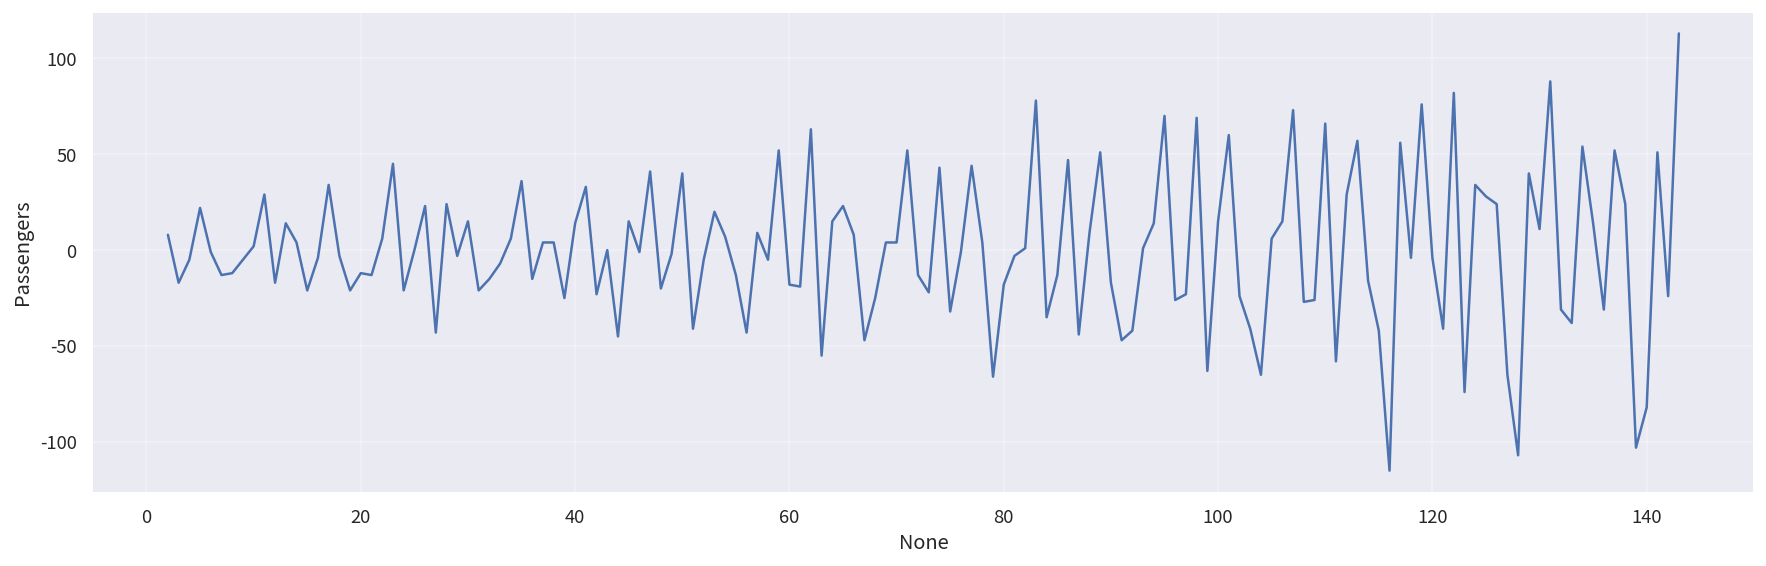

In [5]:
diff_df = origin.copy()
yname = 'Passengers'


# 변수 초기화 
diff_count=0 #몇 번까지 차분을 수행했는지 count
result = [] #결과를 저장할 빈 리스트



while True :
  ar = adfuller(diff_df[yname])   #adfuller() : ADF 정상성 검정 . ar[0] 는 adf 통계량, ar[1] 은 p-value


  #결과를 딕셔너리로 저장
  ar_dict = {
    '차수' : diff_count,   #몇 번 차분했는지
    'ADF Statistic' : ar[0],
    'p value' : ar[1],   #0.05 보다 작아야 정상성이 있다고 판단
    'result' : True if ar [1] <= 0.05 else False     #정상성 통과인지, 아직 비정상인지 표시
  }


  #리스트에 정상성 검사 결과를 저장
  result.append(ar_dict)   #각 차분 단계별 adf 결과를 저장해둠


  #정상성 충족이라면 반복 중단
  if ar_dict['result']:
    break

  #정상성이 충족되지 않았다면 차분 수행 후 다시 수행
  diff_count +=1
  diff_df = diff_df.diff().dropna()

  #ARIMA (p,d,q) 에서 d가 정상성이 될 떄 까지 차분한 횟수를 의미함
  #참고로 p 는 자기회귀 차수 (과거의 값 개수) > PACF 로 찾음 (PACF 가 p에 서 끊김)
  #q는 이동평균 차수 (과거의 오차를 몇 개 볼지) > ACF 로  찾음 (ACF 가 q 에서 끊김)


#차분 결과표
display(DataFrame(result))


#차분의 결과로 생성된 데이터 프레임
display(diff_df.head())



#차분결과 시각화
width_px = 1800
height_px = 600
rows = 1
cols = 1

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.lineplot(data=diff_df, x=diff_df.index, y=yname)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


### #02.ACF (자기 상관 함수 검정 - Auto Correlation Function)
> 과거가 현재에 얼마나 오래 영향을 주는지를 보는 도구


- 시계열 데이터에서 현재 값과 과거 값들 사이의 상관 관계를 시차별로 계산한 함수
- 현재 값이 몇 시점 전까지 영향을 받는지를 전체적으로 보여줌
- 과거 값들과의 상관 관계를 전반적으로 확인하는 도구임


> 시차가 커질수록 상관이 빠르게 사라지면 > 영향이 짧음 
> 천천히 감소하면 > 과거 영향이 오래 지속된다

> 방금 일만 기억하고 금방 까먹는 강아지 > ACF 가 빨리 0
> 예전일도 잘 기억하는 강아지 > ACF 가 천천히 감소

#### 1.ACF 직접 계산하기
1) 수치값 확인

In [7]:
# 목적 : 과거 몇 시점(lag) 까지 현재에 영향을 주는지 자동으로 찾기

# 1. 차분된 시계열의 자기상관계수 (ACF) 계산 (lag 0 부터 시작)
acf_vals = acf(diff_df['Passengers'])  #이미 차분된 시계열 데이터를 acf()함수로 자기상관계수를 모두 계산한다 , 즉 지금 값이 과거의 나와 얼마나 닮았는지 숫자로 나타낸 것 


# 2. ACF 유의성 판단 기준 (근사적 95% 신뢰구간)
threshold = 2 / np.sqrt(len(diff_df['Passengers']))


# 3. 임계값을 초과하는 (유의한) lag 인덱스 추출
significant_lags = np.where (np.abs(acf_vals) >  threshold)[0]  

# 절대값을 씌워서 자기상관계수가 음이든 양이든 상관없이 크기만 보고, 위에서 구한 신뢰구간을 초과하는지 T/ F 로 확인 거기에서 0 번째, 즉 LAG 번호만뽑아내는 것
#WHERE는 TRUE 인 위치만 가져옴


# 4. 결과 확인
acf_vals,threshold,significant_lags


(array([ 1.        , -0.19100587, -0.19598169, -0.0485473 , -0.20664662,
         0.11939696,  0.02575129,  0.14558204, -0.22613908,  0.01407533,
        -0.2082756 , -0.12089977,  0.78224898, -0.09592873, -0.19547382,
        -0.07034343, -0.14794844,  0.11319557,  0.01921939,  0.13695131,
        -0.24015233,  0.02613065]),
 np.float64(0.16783627165933782),
 array([ 0,  1,  2,  4,  8, 10, 12, 14, 20]))

2) 결과표 만들기
  
| 컬럼명              | 의미          | 해석 포인트                                |
| ---------------- | ----------- | ------------------------------------- |
| lag              | 시차          | 몇 시점 전 값과의 상관인지 나타냄 (얼마나 과거의 값을 보는가?) |
| acf              | 자기상관계수      | 해당 lag에서 현재 값과 과거 값의 상관 정도 (−1 ~ 1)   |
| abs_acf          | 자기상관계수의 절댓값 | 상관 방향과 무관하게 영향의 크기만 확인                |
| significant      | 유의성 여부      | |acf| > 2 / √N 여부 → 자기상관 존재 판단        |
| threshold        | 유의성 기준값     | ACF 유의성 판단에 사용하는 기준선                  |
| prev_significant | 이전 lag의 유의성 | 유의성이 연속되는지 판단하기 위한 보조 지표              |
| cut_candidate    | 절단 후보 지점    | 이전 lag는 유의, 현재 lag는 비유의 → 절단 시작 지점    |



🔍 해석 가이드

- significant → 이 lag가 의미 있는가
- prev_significant + cut_candidate → 어디서 영향이 끊기는가
- lag와 cut_candidate를 함께 보면 q 또는 p 후보를 판단할 수 있음

📌 정리
- ACF, PACF는 각각 q 또는 p 값을 찾는 과정
- q 또는 p 값은 통계적 시계열 분석인 ARIMA의 파라미터가 됨

In [8]:
# 1) ACF 계산
acf_vals = acf(diff_df['Passengers'])    #차분된 시계열에서 자기상관계쑤 ACF 를 계산해 배열로 저장
threshold = 2 / np.sqrt(len(diff_df['Passengers']))   #유의수준기준선

# 2) 결과표 생성   > 결과표 데이터 프레임 만들기 / lag 별 acf 값
df_acf = DataFrame({
    "lag": np.arange(len(acf_vals)),
    "acf": acf_vals,
})

# 3) 유의성 판단
df_acf["abs_acf"] = df_acf["acf"].abs()  #상관 방향 무시하고 크기만으로 확인
df_acf["significant"] = df_acf["abs_acf"] > threshold

# 4) 보기 좋게 정리
df_acf["acf"] = df_acf["acf"].round(3)
df_acf["abs_acf"] = df_acf["abs_acf"].round(3)
df_acf["threshold"] = round(threshold, 3)

# 5) lag=0 제외 (판정용)   > lag=0 인 경우는 자기 자신과의 비교라서 항상 1, 분석 방해함
df_acf_result = df_acf.query("lag > 0").reset_index(drop=True)

# 6) 연속 유의 구간 계산 > cut_candidate 만들기 , 즉 끊기는 지점 ㅈ찾기
df_acf_result["prev_significant"] = df_acf_result["significant"].shift(1)    #값을 한 칸 아래로 미는 것

df_acf_result["cut_candidate"] = (
    (df_acf_result["prev_significant"] == True) &
    (df_acf_result["significant"] == False)
)

df_acf_result[["lag", "acf", "significant", "cut_candidate"]]

df_acf_result



,lag,acf,abs_acf,significant,threshold,prev_significant,cut_candidate
0,1,-0.191,0.191,True,0.168,NaN,False
1,2,-0.196,0.196,True,0.168,True,False
2,3,-0.049,0.049,False,0.168,True,True
3,4,-0.207,0.207,True,0.168,False,False
4,5,0.119,0.119,False,0.168,True,True
5,6,0.026,0.026,False,0.168,False,False
6,7,0.146,0.146,False,0.168,False,False
7,8,-0.226,0.226,True,0.168,False,False
8,9,0.014,0.014,False,0.168,True,True
9,10,-0.208,0.208,True,0.168,False,False


3) 결과표 판정
  - ACF 결과표에서 유의한 LAG 의 분포 형태를 이용하여 MA 의 차수 q 를 판단하는 절차
  


- q 후보 판정 규칙
  
| ACF 결과 패턴            | q 판정                                             |
| -------------------- | ------------------------------------------------ |
| 연속적으로 유의한 lag가 없음    | MA(q) 특정하지 않음                                    |
| 저차 lag에서 연속 유의 후 비유의 | 연속 구간의 마지막 lag → q 후보                            |
| 유의 lag가 불연속적으로 분포    | 단순 MA 구조 아님, q 범위만 제한 (특정 값 아님, 구간 설정 필요: 0 ~ q) |

> ACF 애서 유의> 유의하지 않음 으로 바뀌는 지점이 중요함


- 계절성 보조 판단 규칙
  
| 조건                           | 해석               |
| ---------------------------- | ---------------- |
| 고차 lag (예: lag ≥ 6)에서 유의성 관측 | 계절성 성분 존재 가능성    |
| 고차 lag 유의성 없음                | 비계절 MA 구조로 해석 가능 |

> 일정 주기가 있으면 LAG 12, LAG 7 등 월별.주별로 반복되는 특성이 보일 수 있음
>

- 판단 절차 요약
  
| 단계 | 확인 내용                     | 해석                  |
| -- | ------------------------- | ------------------- |
| ①  | significant = True lag 추출 | 자기상관이 의미 있는 시차만 선별  |
| ②  | lag가 연속적인 구간인지 확인         | 연속 여부가 MA 구조 판단의 핵심 |
| ③  | 연속 유의 구간의 마지막 lag 확인      | 해당 lag를 q 후보로 설정    |
| ④  | 고차 lag 유의성 존재 여부 확인       | 계절성 가능성 판단          |

- 계절성 간으성이 있는 경우 q 를 확정하지 않고 q<= q_candidate 범위로만 제한함

> 즉 의미있는 LAG 만 골라내서 그 LAG 들을 연속적으로 보고, 연속이 끊기는 마지막 지점이 q 후보. 멀리 떨어진 lag 에서 다시 튀면 계절성 의심



#### 2. ACF Plot
- 정상 시계열 데이터의 경우 ACF 는 상대적으로 빠르게 0 (상관관계 0) 에 접근함
- 비정상 시계열 데이터의 경우 ACF 는 천천히 감소하며 큰 양의 값을 오래 유지하는 경향이 있음
- 이는 차분 d 가 필요한지 판단하는 참고 기준임

> acf 그래프를 보면 시계열이 정상인지, 차분이 필요한지 알 수 있음.
> 정상 시계열이면 과거가 현재를 조금만 기억해 평균,분산이 일정하고, acf 가 lag 2, lag3 수준에서도 빠르게 0으로 수렴
> 비정상 시계열은 계속 증가하거나 계속 감소하는 추세가 있어 평균이 시간에 따라 변함 , 특히 물가 지수, 누적 매출 등 과거가 현재에 오래 영향을 주는 경우들은 acf 가 천처히 감소하며 오래 양수가 유지된다. 이는 상관성 떄문이라기 보다 추세의 영향 
> 즉, acf 가 빠르게 0으로 가지 않으면 추가적인 차분이 필요하다고 판단할 수 있음
>


1) q 후보 (연속 유의 구간의 마지막 lag)

In [13]:
>

np.int64(2)

2) ACF Plot 시각화

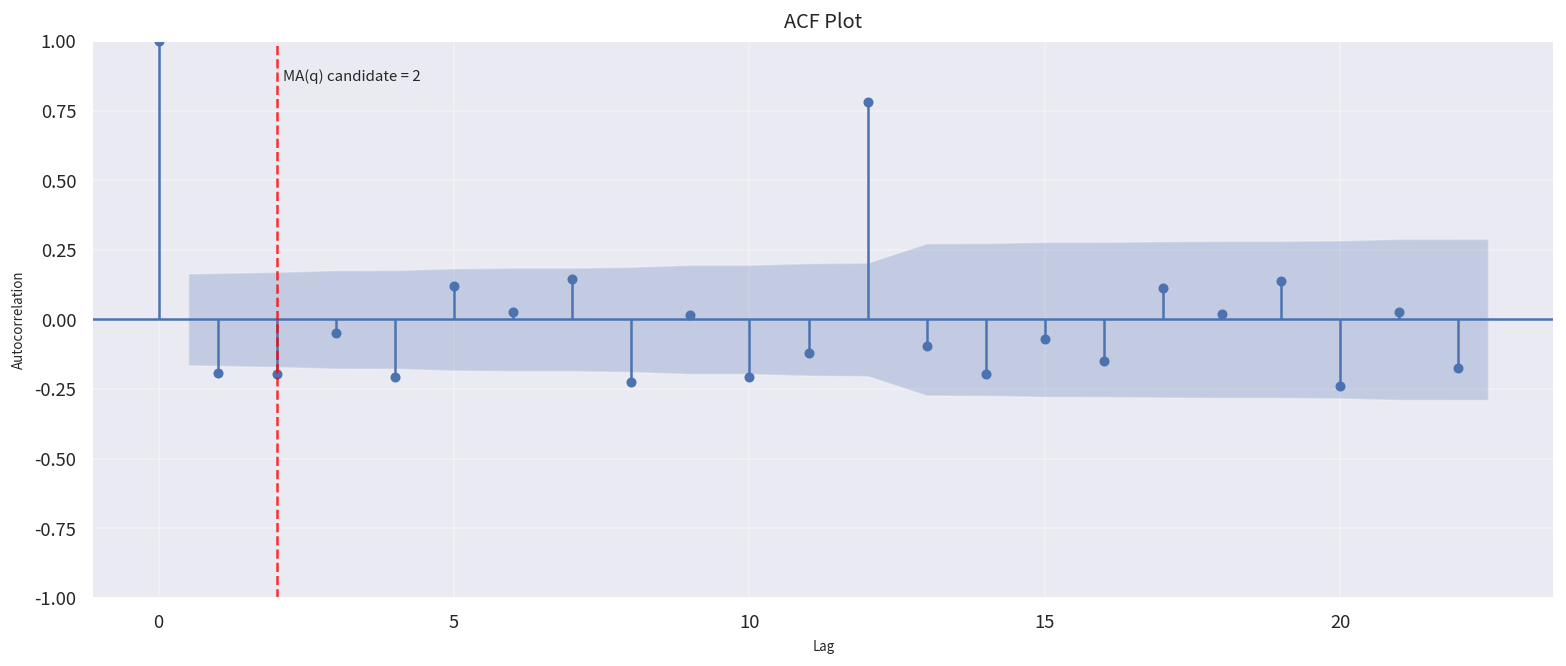

In [14]:
# 1) 그래프 초기화
width_px = 1600          # 그래프 가로 크기
height_px = 700          # 그래프 세로 크기
rows = 1                # 그래프 행 수
cols = 1                # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2-1) ACF Plot 그리기 -> ax 파라미터 필수
plot_acf(diff_df['Passengers'], ax=ax)

# 2-2) MA(q) 후보 시각화
ax.axvline(
    x=q_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color="red"
)

ax.text(
    q_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"MA(q) candidate = {q_candidate}",
    fontsize=9,
    verticalalignment="top"
)

# 3) 그래프 꾸미기
ax.set_title("ACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)   # 배경 격자 표시

# 4) 출력
plt.tight_layout()         # 여백 제거
plt.show()                 # 그래프 화면 출력
plt.close()                # 그래프 작업 종료


### #03.PACF (부분자기상관함수 Partial Auto Correlation Function)

- 특정 시차의 영향만을 다른 시차의 영향은 제거한 상태로 계산한 상관함수
- 해당 시차 자체의 순수한 영향만을 보여줌
- 직접적인 영향만을 분리해서 확인하는 도구
  <직관적 해석>
  - 특정 시차 이후 값들이 거의 0 에 가까우면 그 시차까지만 직접적인 영향이 있다고 해석함

> PACF 는 중간에 낀 과거 영향은 뺴고 해당 시차의 순수한 영향만 본다
> 중간 연결고리는 제거하고 직접 영향 요소만 남기는 것
> PACF 에서 lag p 이후 값들이 거의 0 이면 p 까지만 직접적인 영향이 있다

#### 1.PACF 직접 계산하기
- 결과표 만들기
- 

In [15]:
# 1) PACF 계산
pacf_vals = pacf(diff_df['Passengers'])
threshold = 2 / np.sqrt(len(diff_df['Passengers']))

# 2) 결과표 생성
df_pacf = DataFrame({
    "lag": np.arange(len(pacf_vals)),
    "pacf": pacf_vals,
})

# 3) 유의성 판단
df_pacf["abs_pacf"] = df_pacf["pacf"].abs()
df_pacf["significant"] = df_pacf["abs_pacf"] > threshold

# 4) 보기 좋게 정리
df_pacf["pacf"] = df_pacf["pacf"].round(3)
df_pacf["abs_pacf"] = df_pacf["abs_pacf"].round(3)
df_pacf["threshold"] = round(threshold, 3)

# 5) lag=0 제외
df_pacf_result = df_pacf.query("lag > 0").reset_index(drop=True)

# 6) 연속 유의 구간 계산
df_pacf_result["prev_significant"] = df_pacf_result["significant"].shift(1)

df_pacf_result["cut_candidate"] = (
    (df_pacf_result["prev_significant"] == True) &
    (df_pacf_result["significant"] == False)
)

df_pacf_result[["lag", "pacf", "significant", "cut_candidate"]]

df_pacf_result


,lag,pacf,abs_pacf,significant,threshold,prev_significant,cut_candidate
0,1,-0.192,0.192,True,0.168,NaN,False
1,2,-0.245,0.245,True,0.168,True,False
2,3,-0.159,0.159,False,0.168,True,True
3,4,-0.355,0.355,True,0.168,False,False
4,5,-0.112,0.112,False,0.168,True,True
5,6,-0.169,0.169,True,0.168,False,False
6,7,0.078,0.078,False,0.168,True,True
7,8,-0.329,0.329,True,0.168,False,False
8,9,-0.075,0.075,False,0.168,True,True
9,10,-0.596,0.596,True,0.168,False,False


- 결과표 판정

PACF 결과표에서 유의한 lag의 연속성을 이용하여 자기회귀 차수 p를 판단하는 절차임.

PACF에서는 p는 연속적으로 유의한 부분자기상관 구간의 끝에서 판단한다.

📌 p 후보 판정 규칙
| PACF 결과 패턴           | p 판정                                          |
| -------------------- | --------------------------------------------- |
| 연속적으로 유의한 lag가 없음    | AR(p) 특정하지 않음                                 |
| 저차 lag에서 연속 유의 후 비유의 | 연속 구간의 마지막 lag → p 후보                         |
| 유의 lag가 불연속적으로 분포    | 단순 AR 구조 아님, p 범위만 설정 (특정 값 아님, 구간 필요: 0 ~ p) |

📌 판단 절차 요약
| 단계 | 확인 내용                      | 해석                     |
| -- | -------------------------- | ---------------------- |
| ①  | significant = True인 lag 추출 | 직접적인 자기회귀 효과가 있는 시차 선별 |
| ②  | lag가 연속적인 구간인지 확인          | 연속성이 AR 구조 판단의 핵심      |
| ③  | 연속 유의 구간의 마지막 lag 확인       | 해당 lag를 p 후보로 설정       |


#### 2. PACF PLOT

1) p 후보 (연속 유의 구간의 마지막 lag)

In [19]:

p_candidate = (
    df_pacf_result
        .loc[df_pacf_result["cut_candidate"], "lag"]
        .min() - 1
)

p_candidate


np.int64(2)

2) PACF PLOT 시각화

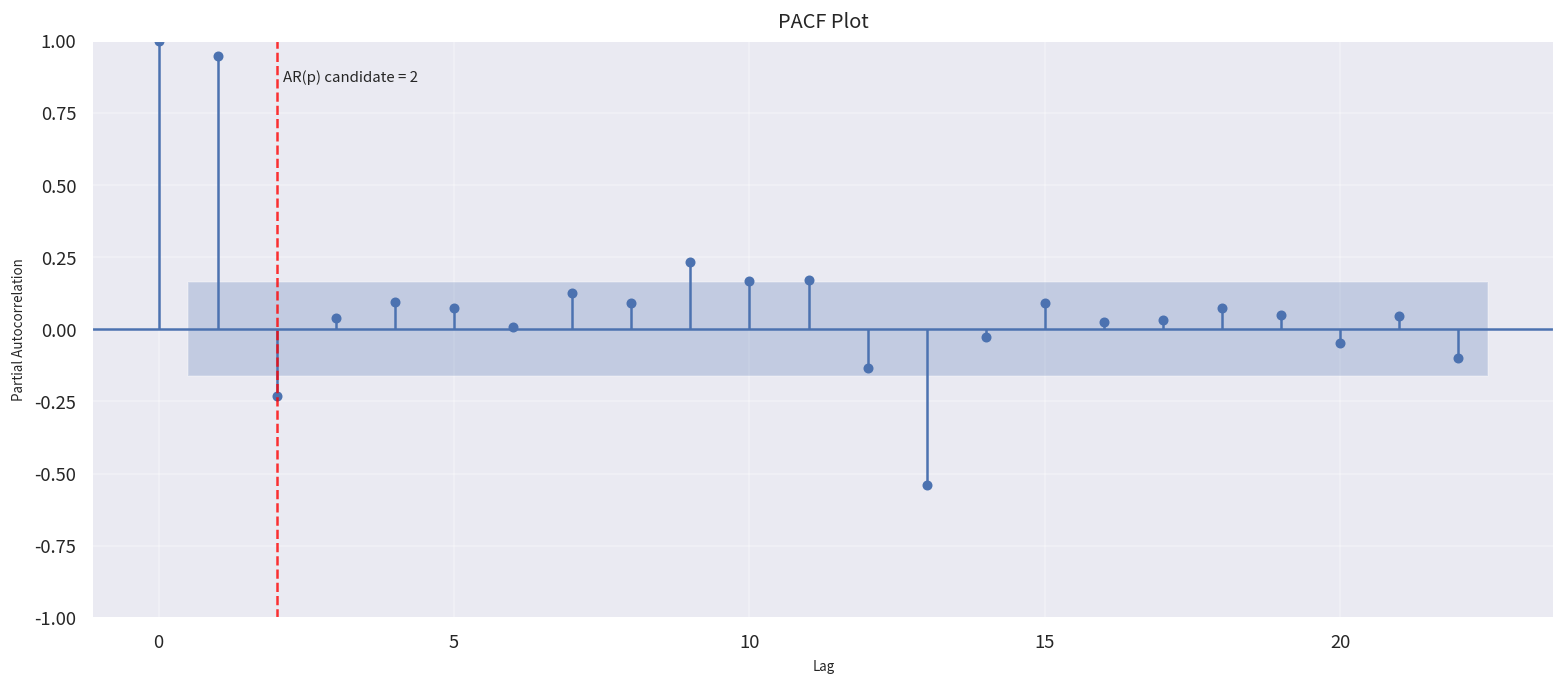

In [20]:
# 1) 그래프 초기화
width_px = 1600
height_px = 720
rows = 1
cols = 1

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2-1) PACF Plot 그리기
plot_pacf(origin['Passengers'], ax=ax)

# 2-2) AR(p) 후보 시각화
ax.axvline(
    x=p_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color="red"
)

ax.text(
    p_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"AR(p) candidate = {p_candidate}",
    fontsize=9,
    verticalalignment="top"
)

# 3) 그래프 꾸미기
ax.set_title("PACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Partial Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


### #04.결과 판정

📌 1. ACF / PACF를 이용한 모형 판정 기준
| 구분   | AR(p) 모델 적합 | MA(q) 모델 적합 |
| ---- | ----------- | ----------- |
| ACF  | 서서히 감소      | q 이후 절단     |
| PACF | p 이후 절단     | 서서히 감소      |


- 절단(cut-off) 이란
→ 신뢰구간(파란 영역) 안으로 들어가 더 이상 유의하지 않게 되는 지점

- 감소 형태는 참고 정보이며
→ 연속 유의 구간이 끝나는 위치가 차수(p, q) 판정의 핵심 기준



📌 2. 왜 ACF와 PACF를 함께 보는가?
- ACF
과거 값들의 전체적인 영향 범위를 보여줌

- PACF
특정 시차의 직접적인 영향 한계를 보여줌

👉 두 결과를 함께 해석하면
비계절 AR 성분(p) 과 MA 성분(q) 을 분리해서 판단할 수 있음



📌 3. ACF, PACF 결과 종합

차분(d)의 차수를 먼저 판단한 뒤
비계절 차수 p ≤ 2, q ≤ 2 범위의 후보를 설정하고
ARIMA 모형으로 확장하여 분석하는 것이 타당

for i in range(0, p+1):
    for j in range(0, q+1):
        ARIMA(i, 2, j)


for d in [1, 2]:
    for i in range(0, p+1):
        for j in range(0, q+1):
            ARIMA(i, d, j)
